In [1]:
import os

# data path
path = os.path.join(os.getenv('HOME'),'aiffel/ocr')

print(path)
print(os.listdir(path + '/data'))

/aiffel/aiffel/ocr
['MJ', 'model_checkpoint.hdf5', 'sample.jpg']


In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")
# 총 36개의 class가 존재함 + 공백 1개 = 37개의 class

The total number of characters is 36


In [3]:
import re
import six
import math
# 데이터는 lmdb format (mdb) 파일로 이루어져 있음
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow import keras

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

# 경로 정의하기
TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


# 데이터 확인해보기


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


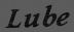

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


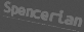

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


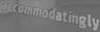

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


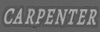

In [4]:
# 데이터 확인해보기

from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

# MJSynthSequnce dataset class for training

코드 설명   

- `dataset_path`는 읽어들일 데이터셋의 경로입니다. 
- `label_converter`는 아래에서 여러분이 문자를 미리정의된 index로 변환해주는 converter로 직접 구현하도록 합니다. 
- 이외에도 batch_size와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있습니다.
- 위의 분석코드처럼 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 `_get_img_label()` 메소드에 반영되었습니다. 
- 그리고 `model.fit()`에서 호출되는 `__getitem__()` 메소드에서 배치 단위만큼 `_get_img_label()` 를 통해 가져온 데이터셋을 리턴하게 될 것입니다. `_get_img_label()` 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있습니다.

In [5]:
# 케라스 모델 학습용 MJSynth 데이터셋 클래스 구현하기

class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


# LabelConverter class for Encoding

코드 설명  
- text를 class id로 mapping 시켜줘야 됨 
- `__init__()`에서는 입력으로 받은 text를 `self.dict`에 각 character들이 어떤 index에 매핑되는지 저장합니다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어집니다. 만약 `character='ABCD'`라면 `'A'`의 label은 `1`, `'B'`의 label은 `2`가 됩니다.
- 공백(blank) 문자를 지정합니다. 여기서는 공백 문자를 뜻하기 위해 `'-'`를 활용하며, label은 0으로 지정합니다.
- `decode()`는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줍니다.

In [6]:
class LabelConverter(object):
    # character : 숫자 , dict 정의하기
    def __init__(self, character):
        # 공백 문자 정의해주기
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i
    
    # mapping 해주기
    def encode(self, text):
        encoded_label = []
        
        for i, char in enumerate(text):
            # 현재 문자가 이전 문자와 같으면 공백 문자에 해당하는 숫자 추가
            if i > 0 and char == text[i-1]:
                encoded_label.append(0) # '-' : 0
            encoded_label.append(self.label_map[char])
        
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        
        for encode in encoded_label:
            decoded_label += self.character[encode]
        
        return decoded_label

In [7]:
# 잘 되는지 확인해보기

# OCR 대상은 영어 + 숫자
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

# 클래스 생성 , init method에 target character 넣어줘야 됨
label_converter = LabelConverter(TARGET_CHARACTERS)

# text to number
encoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encoded_text)

# number to text
decoded_text = label_converter.decode(encoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


# loss function - CTC  

[Tensorflow Tutorial - ctc_batch_cost](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost)

코드 설명   

텐스플로 튜토리얼에 나와있는 내용 
- `y_true`: tensor (samples, max_string_length) containing the truth labels.
- `y_pred`: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
- `input_length tensor`: (samples, 1) containing the sequence length for each batch item in y_pred.
- `label_length tensor`: (samples, 1) containing the sequence length for each batch item in y_true.  
  
이번 데이터셋에서의 내용
- `y_true`: 실제 라벨 LUBE. 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
- `y_pred`: 우리가 만들 RCNN 모델의 출력 결과. 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
- `input_length tensor`: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74
- `label_length tensor`: 라벨의 실제 정답 길이 U로서, 이 경우에는 4 

In [8]:
# CTC loss를 계산하기 위한 Lambda 함수
def ctc_lambda_func(args): 
    # args에는 4개의 값이 들어와야 함 (코드 설명 참고하기)
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


# Build model

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    
    # ConvNet
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    
    # Map-to-sequence
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    
    # BLSTM
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    
    # Transcription Layer
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)
    
    # 같이 인풋으로 들어가야하는 것들
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    
    # CTC loss 계산하기
    # loss 정의할 때는 출력값을 loss로 설정할 것
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        # 4개의 값이 인자로 들어가야 함
        [labels, y_pred, label_length, input_length]
    )
    
    # 모델 인풋으로 들어가는 것들 유의하기
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


In [10]:
model = build_crnn_model()

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 16, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

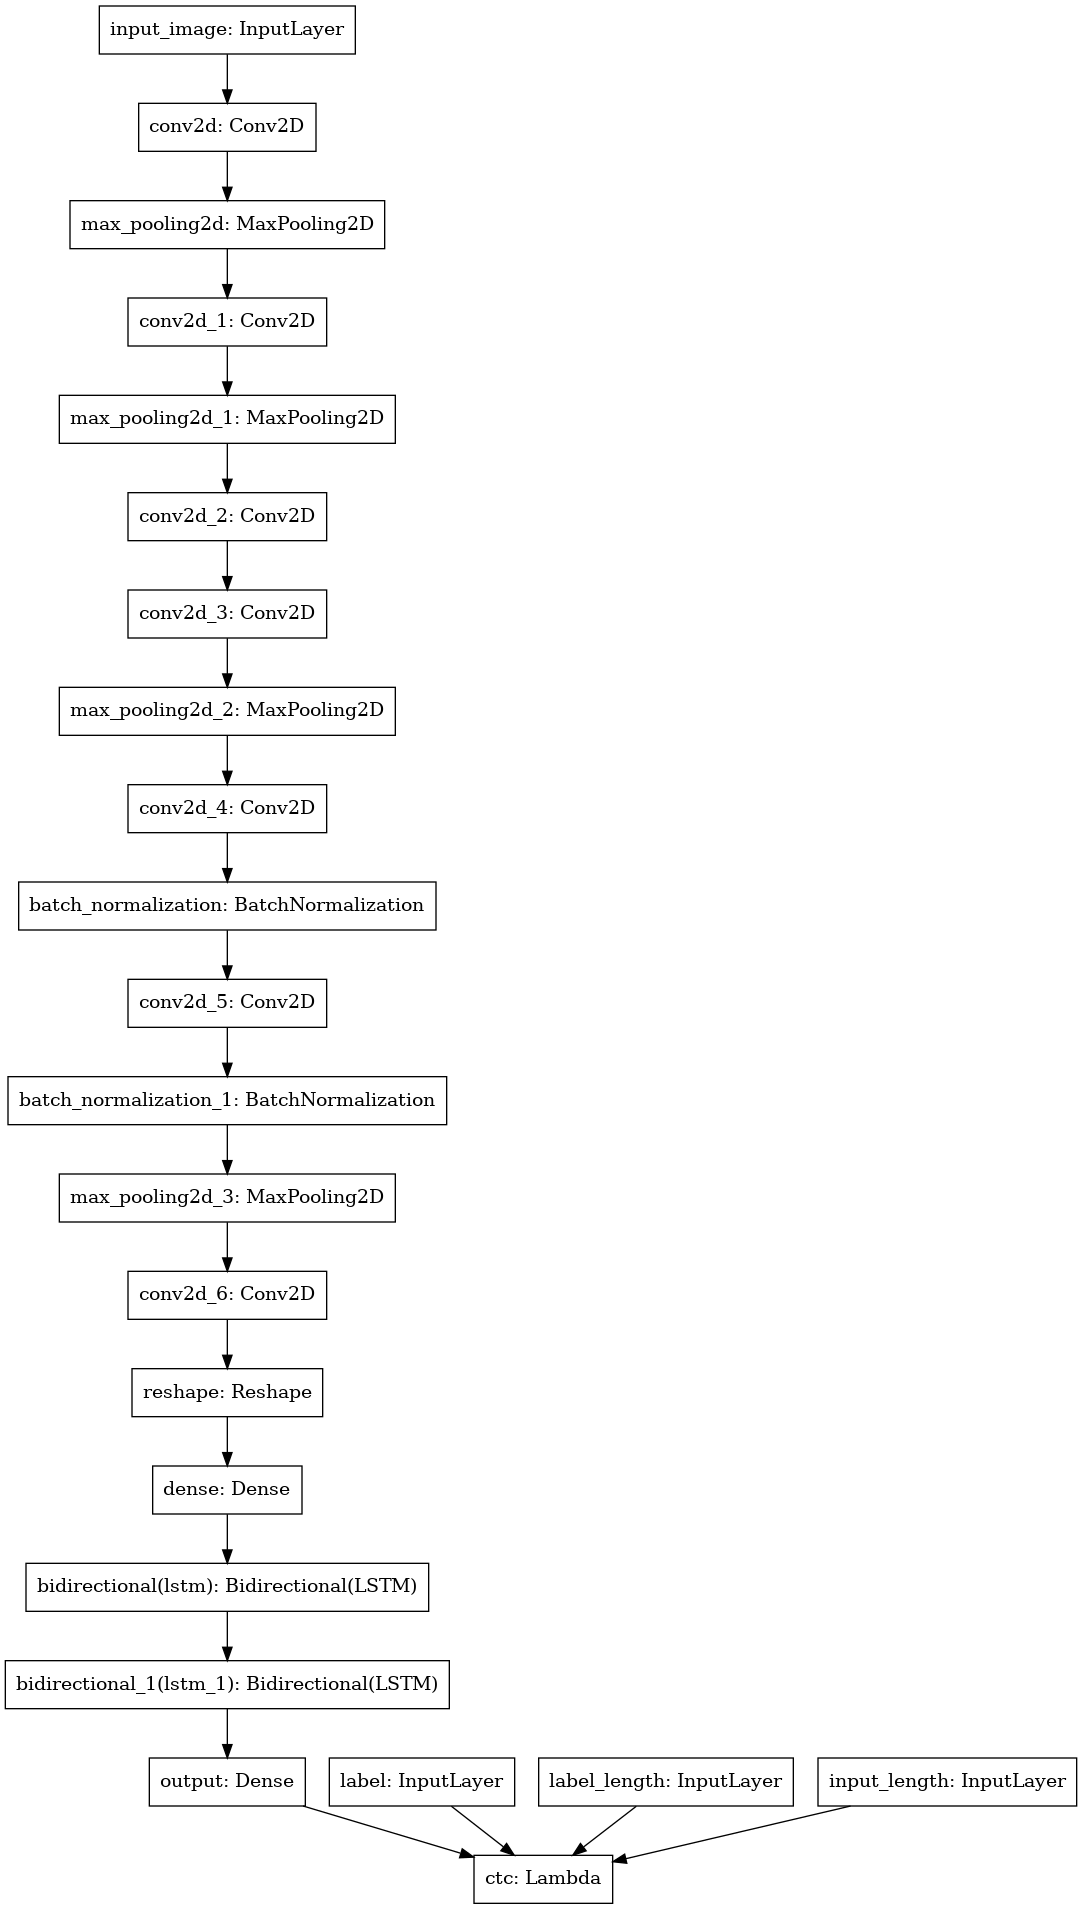

In [12]:
keras.utils.plot_model(model)

# Train & Inference

In [13]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)

# loss 값은 출력값 그대로 전달 
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [14]:
# 학습시키기

# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

# save path
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

# define callback funcs
ckp = keras.callbacks.ModelCheckpoint(
    checkpoint_path,          
    monitor='val_loss',
    save_best_only=True,       
    mode='min',
    save_weights_only=True    
)

earlystop = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=4, 
) 

model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=10,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Epoch 1/10
565/565 [==============================] - 111s 156ms/step - loss: 25.6206 - val_loss: 24.2836
Epoch 2/10
565/565 [==============================] - 82s 145ms/step - loss: 15.4233 - val_loss: 9.8238
Epoch 3/10
565/565 [==============================] - 82s 145ms/step - loss: 7.2704 - val_loss: 6.6115
Epoch 4/10
565/565 [==============================] - 82s 145ms/step - loss: 5.1678 - val_loss: 5.5462
Epoch 5/10
565/565 [==============================] - 82s 145ms/step - loss: 4.0875 - val_loss: 4.8662
Epoch 6/10
565/565 [==============================] - 82s 145ms/step - loss: 3.3391 - val_loss: 4.4534
Epoch 7/10
565/565 [==============================] - 83s 146ms/step - loss: 2.7541 - val_loss: 4.2711
Epoch 8/10
565/565 [==============================] - 82s 145ms/step - loss: 2.2621 - val_loss: 4.0821
Epoch 9/10
565/565 [==============================] - 82s 144ms/step - loss: 1.8491 - val_loss: 4.1815
Epoch 10/10
565/565 [==============================] - 82s 145ms/step